<a href="https://colab.research.google.com/github/marianatmatos/data_science/blob/main/notebooks/Time_Series_with_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series forecasting with Prophet**


[![LinkedIn](https://img.shields.io/badge/linkedIn-MarianaMatos-blue.svg)](https://www.linkedin.com/in/mariana-matos-3ba384175/)
[![GitHub](https://img.shields.io/badge/GitHub-marianatmatos-green.svg)](https://github.com/marianatmatos)

<p align="center">
  <img  height="400" src="https://image.freepik.com/vetores-gratis/adote-um-conceito-de-animal-de-estimacao_23-2148532957.jpg" >
</p>


## **Problem Faced in an Animal Shelter**


Austin Animal Center is the largest no-kill animal shelter in the United States that provides shelter to more than 16,000 animals annually plus animal protection and pet resource services regardless of age, health, species or breed.

The Austin Animal Center is involved in a range of county, city, and state-wide initiatives for the protection and care of abandoned, at-risk, and surrendered animals.

Is part of their misson:
* Provide public service and a safety net for lost and homeless animals in the community. 
* Provide placement services that will assists those animals to their homes or to find a new home. 
* Provide animal services to the public in order to educate and prevent animal homelessness and promote humane, compassionate treatment of animals and responsible pet ownership.

**Their goal** is to place all adoptable animals in forever homes through adoption, foster care, or rescue partner groups and to provide live outcomes for at least 90% of sheltered animals.

The **goal of this project** is analyze the outputs of these animals. With this analysis, expected to be able to identify a adoption pattern, so that in the end it helps to:

1. Plan purchases of inputs (medicines, food...);
2. Hire employees and collaborators;
3. Carry out campaigns to optimize the adoption of animals.

This Notebook is based on a project done by [Sigmoidal](https://sigmoidal.ai/) at *Escola de Data Science*.




### **Data Acquisition**
The data was made available by the [Austin Animal Center](http://www.austintexas.gov/content/austin-animal-center) and can be downloaded directly from the [City of Austin Open Data Portal](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238).

The dataset used in this notebook is constantly **updated** and was updated on **March 30, 2021** and contains **125K rows** and **12 columns**.






In [51]:
# Import libraries 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# configurar a visualização
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [52]:
# Import data to dataframe
PATH = 'https://raw.githubusercontent.com/marianatmatos/data_science/main/datasets/Austin_Animal_Center_Outcomes.csv'
df = pd.read_csv(PATH)

# Convert DateTime column to datetime format
df.DateTime = pd.to_datetime(df.DateTime)

# See fisrt five entries
df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,2019-05-08 18:20:00,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,2018-07-18 16:02:00,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,2020-08-16 11:38:00,08/16/2020 11:38:00 AM,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,2016-02-13 17:59:00,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,2014-03-18 11:47:00,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


Before continuing, it is important to remember that `DateTime` was transform from `string` to `DateTime` and is already in default. If it was not `df.DateTime = pd.to_datetime (df.DateTime, format =% Y-% m-% d)`
`

### **Basic Exploratory Data Analysis**

Remember, this project is focuses on forecasting a time series with Prophet, not EDA, so this is not going to an extensive exploratory data analisys, just enough to get a better understand of the data that can be improved and implement for testing.

#### Column Names & Description

* `Animal ID` 
* `Name` 
* `DateTime` - Animal Arrival Date
* `MonthYear` - Arrival Month and Year
* `Date of Birth` 
* `Outcome Type` - Output Type (e.g. Adoption)
* `Outcome Subtype` - Kind of Reason for Exit (e.g. medical reason)
* `Animal Type`
* `Sex upon Outcome`
* `Age upon Outcome` - Age at Departure
* `Breed`
* `Color` 



#### A brief description 
according to the Pandas documentation:

* **count**   - sum of all column values
* **unique**  - sum of all unique values 
* **top**     - the most common value
* **freq**    - the most common value’s frequency
* **first**   - first timestamp value
* **last**    - last timestamp value


In [53]:
# Statistical summary
df.describe()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
count,125126,85955,125126,125126,125126,125105,57675,125126,125124,125123,125126,125126
unique,111866,19882,103489,103489,7138,9,23,5,5,52,2638,599
top,A721033,Max,2016-04-18 00:00:00,04/18/2016 12:00:00 AM,04/21/2014,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,33,563,39,39,117,55622,30977,70887,44000,22240,31354,13135
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2021-04-01 10:41:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Statistical Distribution Highlights

* The most frequent animal in the shelter is a dog
* Most animals leave the shelter at the age of 1
* More than 50% of the animals in the shelter are adopted 
* People prefer to adopt Neutered Male (most dogs)



In [54]:
# Summary of variable types and NaN values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125126 entries, 0 to 125125
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal ID         125126 non-null  object        
 1   Name              85955 non-null   object        
 2   DateTime          125126 non-null  datetime64[ns]
 3   MonthYear         125126 non-null  object        
 4   Date of Birth     125126 non-null  object        
 5   Outcome Type      125105 non-null  object        
 6   Outcome Subtype   57675 non-null   object        
 7   Animal Type       125126 non-null  object        
 8   Sex upon Outcome  125124 non-null  object        
 9   Age upon Outcome  125123 non-null  object        
 10  Breed             125126 non-null  object        
 11  Color             125126 non-null  object        
dtypes: datetime64[ns](1), object(11)
memory usage: 11.5+ MB


#### Check missing values
Note that `Name` and `Outcome Subtype` have missing values, as well as `Sex upon Outcome`, `Age upon Outcome` and `Outcome Type`, although it in a smaller quantity.

Since we are using only `DateTime`, `Outcome Type` and other feature - that we are creating next - we are not going to worry about the other missing values. 


In [55]:
# Count NaN values
df.isnull().sum()

Animal ID               0
Name                39171
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type           21
Outcome Subtype     67451
Animal Type             0
Sex upon Outcome        2
Age upon Outcome        3
Breed                   0
Color                   0
dtype: int64

Most animals were adopted, transferred, or return to their owner.

In [56]:
# See Outcome types
df['Outcome Type'].value_counts()

Adoption           55622
Transfer           36885
Return to Owner    21600
Euthanasia          8468
Died                1161
Rto-Adopt            706
Disposal             571
Missing               70
Relocate              22
Name: Outcome Type, dtype: int64

### **Create new DataFrame**
In order to work with time series using [Prophet](https://facebook.github.io/prophet/) we need a DataFrame with only two columns,
column ds (standardized DateTime) and column y (number of recorded events)
for this, only the value `Adoption` was selected from the `Result Type` column.
and then a new `ResultCount` column was created which was assigned 1 to all values.
And to follow the pattern proposed by the Prophet, we assign the 'DateTime' column to the index.

In [57]:
# View only 'Adoption'
adoptions_df = df[(df['Outcome Type'] == 'Adoption')]
adoptions_df['outcomeCount'] = 1

# Create new DataFrame with 'DateTime' and 'outcomeCount'
adoptions_df = adoptions_df[['DateTime', 'outcomeCount']]
adoptions_df = adoptions_df.set_index('DateTime').sort_index()
adoptions_df.head()

,outcomeCount
DateTime,
2013-10-01 09:31:00,1
2013-10-01 11:42:00,1
2013-10-01 11:53:00,1
2013-10-01 11:53:00,1
2013-10-01 15:47:00,1


In [58]:
# See min Date and max Date
adoptions_df.index.min(), adoptions_df.index.max()

(Timestamp('2013-10-01 09:31:00'), Timestamp('2021-04-01 10:17:00'))

Here Pandas `resample ()` method will be used to change the time interval, in this case, we use the resample to sum the values ​​for each day and month.

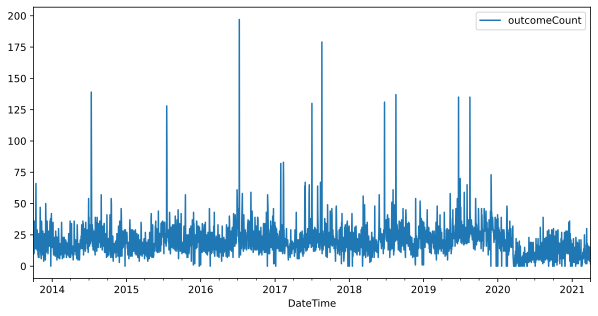

In [59]:
# Plot Daily graph
fig, ax = plt.subplots(figsize=(10,5))
adoptions_df.resample('D').sum().plot(ax=ax)
plt.show()

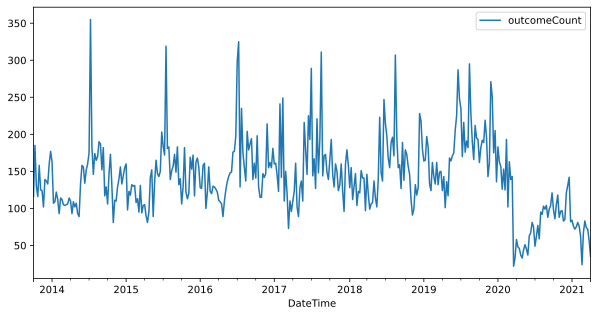

In [60]:
# Plot weekly graph
fig, ax = plt.subplots(figsize=(10,5))
adoptions_df.resample('W').sum().plot(ax=ax)
plt.show()

### **Forecasting with Prophet**

**Prophet** is a  **Facebook** project that emerged to solve internal company problems, however it became open source and the documentation can be viewed [here](https://facebook.github.io/prophet/).

> "Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."




As it was said before, Prophet only need two variables to work the forecasts:

- `ds`: Date.
- `y`: Numeric value forecast target

We are going to work with daily data and weekly data.

#### Daily model

In [61]:
# Create DataFrame according to documentation with ds and y coulmns
prophet_df = adoptions_df.resample('D').sum().reset_index().rename(columns={'DateTime':'ds', 'outcomeCount':'y'})
prophet_df.head()

,ds,y
0,2013-10-01,11
1,2013-10-02,16
2,2013-10-03,10
3,2013-10-04,11
4,2013-10-05,36


In [62]:
# Instantiate and train the model
model = Prophet()
model.add_country_holidays(country_name='US')
model.fit(prophet_df)

# Set forecasting period 
future = model.make_future_dataframe(periods=365)

# forecasting for the established period
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


We can see some outliers in the graph

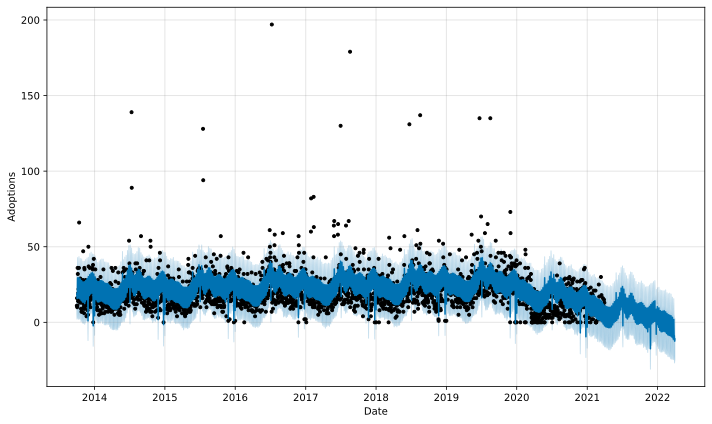

In [63]:
# Plot graph with daily forecast
model.plot(forecast, xlabel='Date', ylabel='Adoptions');

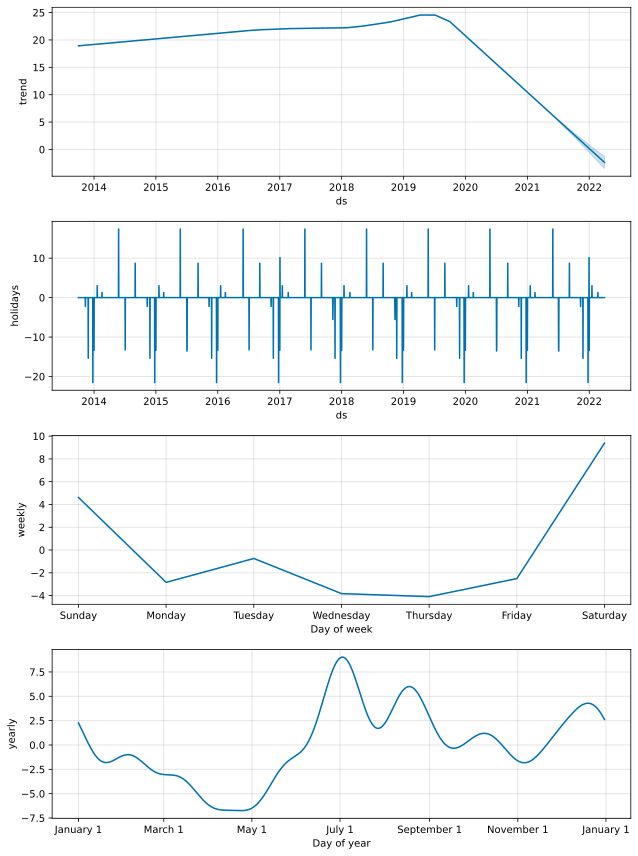

In [64]:
# Separate model components
model.plot_components(forecast);

Here we can see in more detail how the holidays and vacations influence the number of adoptions

#### Weekly Model

In [65]:
# Create DataFrame based on weekly reports
prophet_df2 = adoptions_df.resample('W').sum().reset_index().rename(columns={'DateTime':'ds', 'outcomeCount':'y'})

# Instantiate and train model
model2 = Prophet()
model2.add_country_holidays(country_name='US')
model2.fit(prophet_df2)

# Set forecasting period 
future2 = model2.make_future_dataframe(periods=52)

# # forecasting for the established period
forecast2 = model2.predict(future2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


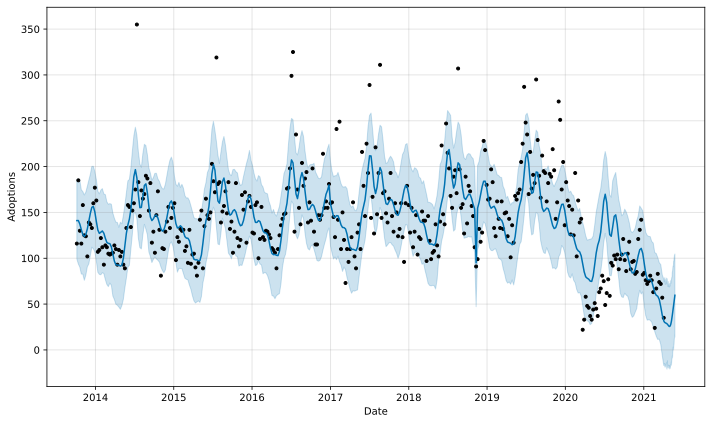

In [66]:
# Plot graph with weekly forecast
model2.plot(forecast2, xlabel='Date', ylabel='Adoptions');

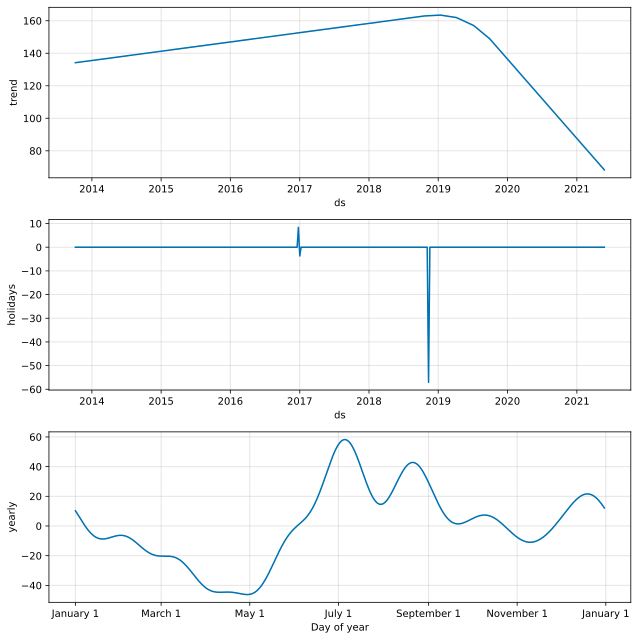

In [67]:
# Separate model components
model2.plot_components(forecast2);

### **Model Validation**


#### Daily Model

In [68]:
# Cross Validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 8 forecasts with cutoffs between 2016-10-01 12:00:00 and 2020-04-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-10-02,30.139073,19.692336,42.137636,21,2016-10-01 12:00:00
1,2016-10-03,18.920796,7.421803,31.736024,19,2016-10-01 12:00:00
2,2016-10-04,19.797399,7.829174,31.438606,13,2016-10-01 12:00:00
3,2016-10-05,17.907449,5.690272,29.915320,26,2016-10-01 12:00:00
4,2016-10-06,17.854164,6.198104,28.130464,25,2016-10-01 12:00:00


In [69]:
# PErformance Metrics
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,36 days 12:00:00,83.907275,9.160091,7.001614,0.275806,0.869863
1,37 days 00:00:00,84.293865,9.181169,7.032653,0.279563,0.869863
2,37 days 12:00:00,84.325307,9.182881,7.034295,0.279563,0.869863
3,38 days 00:00:00,86.607786,9.306330,7.130283,0.284337,0.866438
4,38 days 12:00:00,85.957889,9.271348,7.076147,0.279563,0.869863


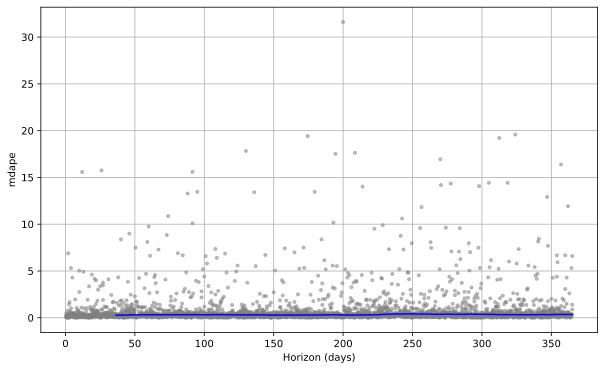

In [70]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mdape')

#### Weekly Model

In [71]:
# Cross Validation
from fbprophet.diagnostics import cross_validation
df_cv2 = cross_validation(model2, horizon= '365 days')
df_cv2.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2017-04-05 00:00:00 and 2020-04-04 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-04-09,113.730073,79.079954,147.518269,123,2017-04-05
1,2017-04-16,117.189575,82.751375,151.368979,161,2017-04-05
2,2017-04-23,121.621791,87.744367,157.015127,102,2017-04-05
3,2017-04-30,123.430394,89.058129,156.692933,89,2017-04-05
4,2017-05-07,125.632062,92.593710,158.155157,128,2017-04-05


In [72]:
# Performance Metrics 
from fbprophet.diagnostics import performance_metrics
df_p2 = performance_metrics(df_cv2)
df_p2.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 00:00:00,1797.529539,42.397282,30.471980,0.462209,0.135295,0.750000
1,36 days 12:00:00,1725.370532,41.537580,29.855790,0.435581,0.135295,0.750000
2,37 days 00:00:00,1759.538394,41.946852,30.524914,0.439481,0.149418,0.750000
3,37 days 12:00:00,1831.609937,42.797312,31.936089,0.455000,0.160137,0.722222
4,38 days 00:00:00,1831.088012,42.791214,31.921306,0.456456,0.160137,0.722222


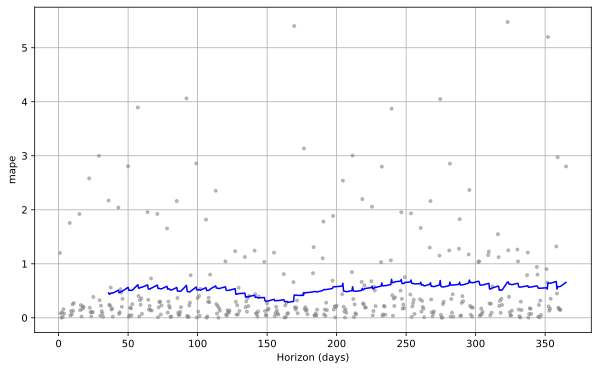

In [73]:
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv2, metric='mape');

### **Conclusion**

The weekly model had a lower margin of error when compared to the daily model, but the margin of error for both is still high so the forecasts would not be well accepted.

> For the Daily model:
* mdape around 28%

> For the Weekly model:
* mdape	around 45%
* mape around 15%

### **What if...**
We check stationarity in our Time Series?

One of the things we can do to try and improve our results is making our Time Series stationary. 


#### Stationary Test

We'll run ADF test to check if our data is stationary. The null hipothesis is that our Time Series is **not** stationary and an alternative hypothesis that our Serie is stationary.

If the alternative hypothesis got rejected we'll transform it into stationary series, make new forecasts, and validate our new model.

In [79]:
from statsmodels.tsa.stattools import adfuller

# Extract value
X = prophet_df.y

# Apply ADF test for daily dataframe
result = adfuller(X)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result[0]))
print('P Value: {:.10f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Augmented Dickey–Fuller
Statistical Test: -4.0285
P Value: 0.0012683754
Critical Values:
	1%: -3.4328
	5%: -2.8626
	10%: -2.5673


In [80]:
# Extract value
X = prophet_df2.y

# Apply ADF test for daily dataframe
result = adfuller(X)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result[0]))
print('P Value: {:.10f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Augmented Dickey–Fuller
Statistical Test: -4.0305
P Value: 0.0012589418
Critical Values:
	1%: -3.4473
	5%: -2.8690
	10%: -2.5708


### **Conclusion**

Our P-Value from the daily dataframe is 0.0012 and for the weekly dataframe is also 0.0012 which means that we reject the null hypothesis from both tests and accept the alternative hypothesis that our series is stationary.


## Thank You!
[![](https://img.shields.io/badge/contributions-welcome-green.svg)](https://github.com/marianatmatos/data_science/issues)

Thank you for your time and attention. I hope this was an informative and interesting project. If you have any questions or any kind of feedback, feel free to contact me on [LinkedIn](https://www.linkedin.com/in/mariana-matos-3ba384175/), and check out my other projects on [GitHub](https://github.com/marianatmatos).

